# Implementation of GAN for MNIST digit generation for Sony CSL internship

This is a simple implementation of a GAN, cGAN, e-cGAN and VAEGAN in pytorch for MNIST digit generation.

Reasoning and other comments will be available throughout the notebook in the markdown cells.


## Setup

We begin by importing the required libraries and the MNIST dataset, while defining the key global hyperparameters


### Imports and global variables

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from PIL import Image
from IPython.display import display

# Global hyperparameters
batch_size = 64
device = torch.device("mps")

# GAN Loss function
loss = nn.BCELoss()

# Encoder Loss function
loss_enc = nn.L1Loss()
# loss_enc = nn.MSELoss()


# MNIST is grayscale, so 1 channel
img_channel = 1

# label for real and fake images
real_val = 1
fake_val = 0

# Import dataset, normalise and load into dataloader
mnist = MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]),
)

dataloader = torch.utils.data.DataLoader(
    mnist, batch_size=batch_size, shuffle=True, num_workers=2
)

### MNIST Examples

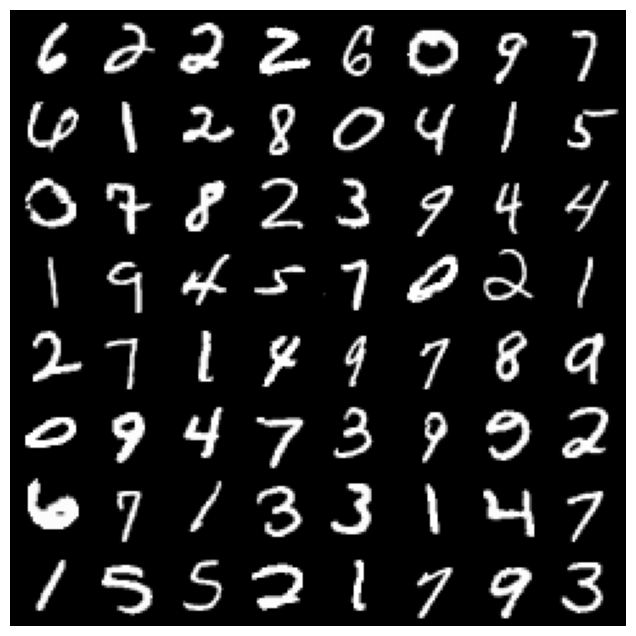

In [2]:
examples = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
grid = np.transpose(
    torchvision.utils.make_grid(examples[0][:64], padding=2, normalize=True),
    (1, 2, 0),
)
plt.imshow(grid)

## Vanilla Generative Adversarial Network (GAN)

<div>
<img src="GAN.png" width="600"/>
</div>

This version of the GAN architecture is quite simple and just simply generates random digits from input noise. The user has no control over the digit that is generated so its not unlikely that the model could suffer from mode collapse.

I've implemented a DCGAN as described in the paper [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf) by Radford et al. (2015) which uses transposed convolutions in the generator and convolutions in the discriminator as well as the prescribed batch norm, leaky relu and normal distribution weight initialisation. Before implementing the weight initialisation I was getting checkerboard artificafts in the generated images, which is a common problem with strided transposed convolutions. I initially tried upsampling using NN before using plain convolutional layers with no striding but the weight initalisation is a much neater solution.

This ends up taking a long time to converge to anything worthwhile, it could possibly be sped up by implementing techniques such as minibatch discrimination as described in the paper [Improved Techniques for Training GANs](https://arxiv.org/pdf/1606.03498.pdf) by Salimans et al. (2016). It would also be worth implementing a method of saving and loading model checkpoints so that the model can be trained over multiple sessions.

Bear in mind the training shown here is the last 20 epochs of trainings out of 100. but even then, this clearly isn't the best model structure / parameter set for this task and more tuning is required.

### Model Architecture

In [8]:
class Generator(nn.Module):
    def __init__(self, hidden_dim, latent_dim, img_channel):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.img_channel = img_channel
        
        self.model = nn.Sequential(
            # Input
            nn.Linear(latent_dim, hidden_dim * 4 * 7 * 7),
            nn.BatchNorm1d(hidden_dim * 4 * 7 * 7),
            nn.ReLU(True),
            nn.Unflatten(1, (hidden_dim * 4, 7, 7)),
            # First upsample layer (to 14x14)
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),
            # Second upsample layer (to 28x28)
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),
            # Collapse to img_channel
            nn.ConvTranspose2d(hidden_dim, img_channel, 5, 1, 2, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.model(z)
    

    
class Discriminator(nn.Module):
    def __init__(self, hidden_dim, img_channel):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.img_channel = img_channel

        self.model = nn.Sequential(
            # First downsample layer (to 14x14)
            nn.Conv2d(img_channel, hidden_dim, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            # Second downsample layer (to 7x7)
            nn.Conv2d(hidden_dim, hidden_dim * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Output
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 2 * 7 * 7, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)
    


def init_weight(model):
    def _init_weight(module):
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d):
            nn.init.normal_(module.weight, 0., 0.02)
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.normal_(module.weight, 1.0, 0.02)
            nn.init.constant_(module.bias, 0)

    model.apply(_init_weight)
    


# Model Hyperparameters
latent_dim = 100
hidden_dim = 64

# Initialise generator and discriminator
generator = Generator(
    hidden_dim, latent_dim, img_channel).to(device)
#print(generator)

discriminator = Discriminator(
    hidden_dim, img_channel).to(device)
#print(discriminator)

init_weight(generator)
init_weight(discriminator)

### Training Functions

In [4]:
def dis_train_step(batch_size, gen, dis, dis_optimiser, loss, real_img):
    # Clear Gradients
    dis_optimiser.zero_grad()

    # Generate labels
    real_vals = torch.full((batch_size,), real_val, dtype=torch.float, device=device)
    fake_vals = torch.full((batch_size,), fake_val, dtype=torch.float, device=device)

    # Train on Real Data
    validity = dis(real_img).squeeze(-1)
    real_loss = loss(validity, real_vals)

    # Train on Fake Data
    noise = torch.randn(batch_size, 100, device=device)
    fake = gen(noise)
    validity = dis(fake).squeeze(-1)
    fake_loss = loss(validity, fake_vals)

    # Update Weights
    d_loss = real_loss + fake_loss
    d_loss.backward()
    dis_optimiser.step()
    return d_loss.item()


def gen_train_step(batch_size, gen, dis, gen_optimiser, loss):
    # Clear Gradients
    gen_optimiser.zero_grad()

    # Generate labels
    real_vals = torch.full((batch_size,), real_val, dtype=torch.float, device=device)

    # Train on Fake Data
    noise = torch.randn(batch_size, 100, device=device)
    fake = gen(noise)
    validity = dis(fake).squeeze(-1)
    g_loss = loss(validity, real_vals)

    # Update Weights
    g_loss.backward()
    gen_optimiser.step()
    return g_loss.item()

### Training


Epoch 1


g_loss: 0.725195586681366, d_loss: 1.40447199344635: 100%|██████████| 938/938 [00:56<00:00, 16.52it/s]   

Final Avg: g_loss: 0.7209520606216846, d_loss: 1.3794928738303276


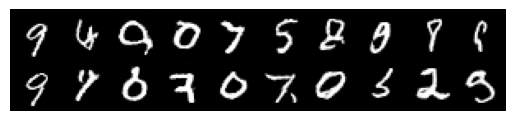

Epoch 2


g_loss: 0.7069059610366821, d_loss: 1.3836119174957275: 100%|██████████| 938/938 [00:57<00:00, 16.36it/s]

Final Avg: g_loss: 0.7200470176586973, d_loss: 1.3808260641372534


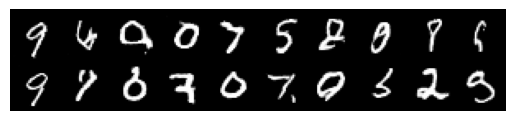

Epoch 3


g_loss: 0.7252054214477539, d_loss: 1.3772377967834473: 100%|██████████| 938/938 [00:56<00:00, 16.74it/s]

Final Avg: g_loss: 0.7184065942571107, d_loss: 1.3799471315036196


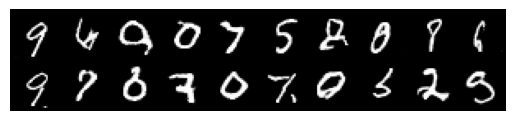

Epoch 4


g_loss: 0.7017041444778442, d_loss: 1.3923583030700684: 100%|██████████| 938/938 [00:55<00:00, 16.99it/s]

Final Avg: g_loss: 0.7184378438031496, d_loss: 1.379600416876868


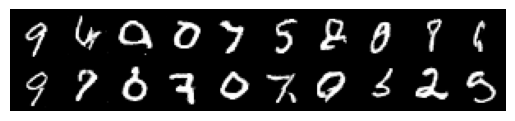

Epoch 5


g_loss: 0.7100875377655029, d_loss: 1.3827903270721436: 100%|██████████| 938/938 [00:55<00:00, 17.04it/s]

Final Avg: g_loss: 0.7185902355957642, d_loss: 1.3805132622657807


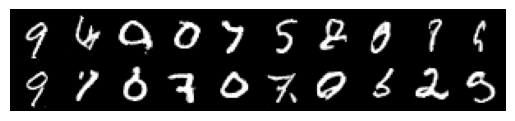

Epoch 6


g_loss: 0.7425057888031006, d_loss: 1.378986120223999: 100%|██████████| 938/938 [00:55<00:00, 17.03it/s] 

Final Avg: g_loss: 0.7183792209193143, d_loss: 1.378444001745822


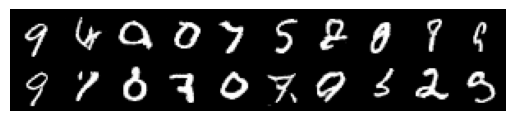

Epoch 7


g_loss: 0.7135652303695679, d_loss: 1.3924214839935303: 100%|██████████| 938/938 [00:56<00:00, 16.73it/s]

Final Avg: g_loss: 0.7181891507939744, d_loss: 1.3796533011932617


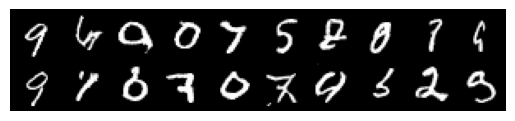

Epoch 8


g_loss: 0.6610952615737915, d_loss: 1.4249227046966553: 100%|██████████| 938/938 [00:55<00:00, 16.83it/s]

Final Avg: g_loss: 0.7192484812695843, d_loss: 1.3805142918121078


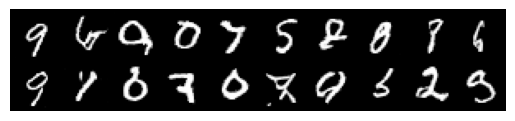

Epoch 9


g_loss: 0.6929349303245544, d_loss: 1.396404504776001: 100%|██████████| 938/938 [00:55<00:00, 16.93it/s] 

Final Avg: g_loss: 0.7187865378378805, d_loss: 1.3796273828315329


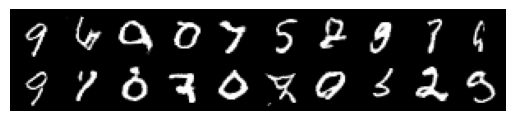

Epoch 10


g_loss: 0.7024345993995667, d_loss: 1.3543403148651123: 100%|██████████| 938/938 [00:55<00:00, 16.99it/s]

Final Avg: g_loss: 0.7182288627380501, d_loss: 1.3800838484184574


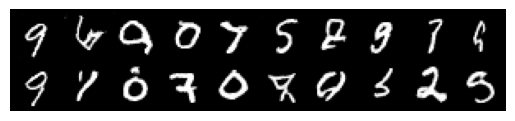

Epoch 11


g_loss: 0.756456196308136, d_loss: 1.3609191179275513: 100%|██████████| 938/938 [00:55<00:00, 16.89it/s] 

Final Avg: g_loss: 0.7176280962124563, d_loss: 1.3790588833884136


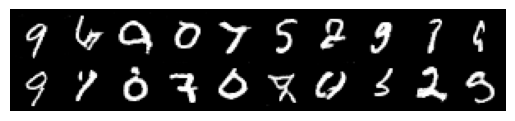

Epoch 12


g_loss: 0.7426587343215942, d_loss: 1.3526792526245117: 100%|██████████| 938/938 [00:57<00:00, 16.31it/s]

Final Avg: g_loss: 0.7186670861264536, d_loss: 1.3799276895868753


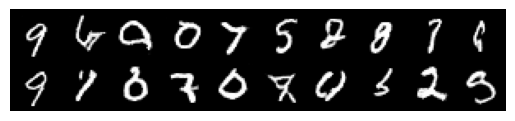

Epoch 13


g_loss: 0.7198324203491211, d_loss: 1.3377254009246826: 100%|██████████| 938/938 [00:56<00:00, 16.54it/s]

Final Avg: g_loss: 0.7172965058512779, d_loss: 1.3798020266012343


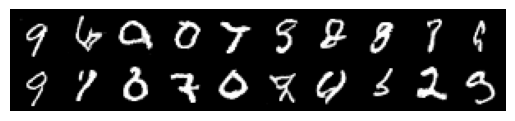

Epoch 14


g_loss: 0.7102948427200317, d_loss: 1.3938817977905273: 100%|██████████| 938/938 [00:55<00:00, 17.00it/s]

Final Avg: g_loss: 0.7186581457474592, d_loss: 1.3787246145673397


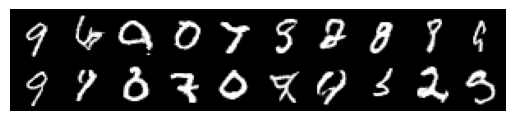

Epoch 15


g_loss: 0.7141040563583374, d_loss: 1.4051134586334229: 100%|██████████| 938/938 [00:55<00:00, 17.05it/s]

Final Avg: g_loss: 0.7182721409207976, d_loss: 1.379510238734898


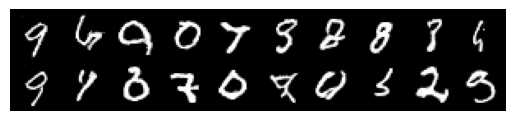

Epoch 16


g_loss: 0.7178164720535278, d_loss: 1.4113441705703735: 100%|██████████| 938/938 [00:55<00:00, 16.77it/s]

Final Avg: g_loss: 0.7170515740985302, d_loss: 1.379534839567091


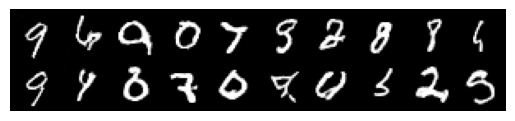

Epoch 17


g_loss: 0.7124857902526855, d_loss: 1.3715879917144775: 100%|██████████| 938/938 [00:55<00:00, 16.92it/s]

Final Avg: g_loss: 0.7168017258522099, d_loss: 1.3788198171648136


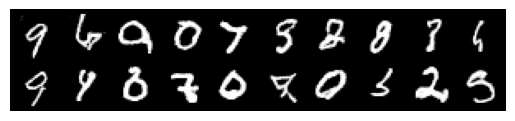

Epoch 18


g_loss: 0.7492078542709351, d_loss: 1.4166998863220215: 100%|██████████| 938/938 [00:55<00:00, 16.92it/s]

Final Avg: g_loss: 0.7164307036506596, d_loss: 1.3810065407742824


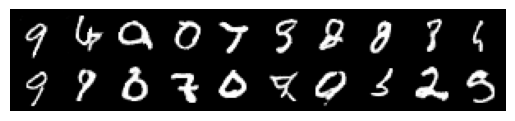

Epoch 19


g_loss: 0.7559643387794495, d_loss: 1.3997776508331299: 100%|██████████| 938/938 [00:56<00:00, 16.69it/s]

Final Avg: g_loss: 0.7177577096897402, d_loss: 1.3777358065536027


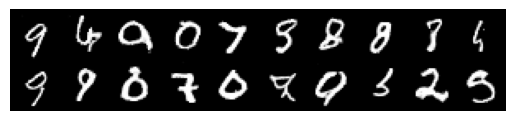

Epoch 20


g_loss: 0.7400872707366943, d_loss: 1.3398761749267578: 100%|██████████| 938/938 [00:55<00:00, 16.91it/s]

Final Avg: g_loss: 0.7177842090378946, d_loss: 1.3789452625744378


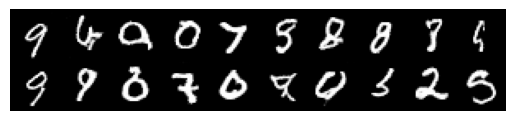

In [24]:
# total number of epochs to train the model
num_epochs = 20

# constant inputs for visualisation
test_noise = torch.randn(20, 100, device=device)

# optimisers
lr = 0.0002
dis_optimiser = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
gen_optimiser = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

# Train the model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    dis_loss_sum = 0
    gen_loss_sum = 0
    data_iter = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, (images, label) in data_iter:
        # Prepare batch
        real_img = images.to(device)
        generator.train()
        batch_size = real_img.shape[0]

        # Train discriminator
        dis_loss = dis_train_step(
            batch_size, generator, discriminator, dis_optimiser, loss, real_img
        )

        # Train generator
        gen_loss = gen_train_step(
            batch_size, generator, discriminator, gen_optimiser, loss
        )

        # Update running loss
        dis_loss_sum += dis_loss
        gen_loss_sum += gen_loss
        if i % 50 == 0:
            data_iter.set_description(
                "g_loss: {}, d_loss: {}".format(gen_loss, dis_loss)
            )
            

    # average loss over epoch
    print(
        "Final Avg: g_loss: {}, d_loss: {}".format(
            gen_loss_sum / len(dataloader), dis_loss_sum / len(dataloader)
        )
    )
    generator.eval()

    # visualise generated images
    sample_images = generator(test_noise).cpu()
    grid = (
        torchvision.utils.make_grid(sample_images, nrow=10, padding=2, normalize=True)
        .permute(1, 2, 0)
    )
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

### Reconstructed Digits
Epoch 100

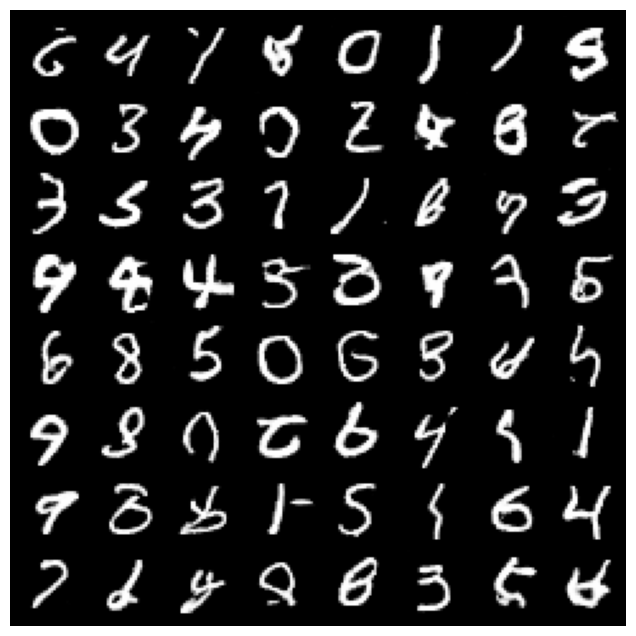

In [25]:
generator.eval()
sample_noise = torch.randn(64, 100, device=device)
sample_images = generator(sample_noise).cpu()
plt.figure(figsize=(8, 8))
grid = torchvision.utils.make_grid(sample_images, nrow=8, padding=2, normalize=True).permute(1,2,0).numpy()
plt.imshow(grid)
plt.axis("off")
plt.show()

## Conditional GAN (cGAN)

<div>
<img src="cGAN.png" width="600"/>
</div>

The cGAN architecture is similar to the GAN architecture except that the generator and discriminator are conditioned on the class label. This means that the user can specify which digit they want to generate. Not only does this give the user more control, it also ensures the model can generate an example from each of the input classes.

This approach is introduced within the paper [Conditional Generative Adversarial Nets](https://arxiv.org/pdf/1411.1784.pdf) by Mirza et al. (2014). In this paper the authors use a naive approach of one-hot encoding the class label and concatenating it with the input noise vector. Generally the more well used approaches since seem to be to encode the class labels using an embedding layer and injecting them into the generator at various stages during the generation process, encouraging the model to still learn a distribution over the class labels. In our case, we will inject our embedding as an extra image channel before the upscaling layers in the generator.

<div>
<img src="Emb.png" width="800"/>
</div>

Just adding conditioning information clearly makes the model learn miles faster than the vanilla GAN. This makes sense as you the model only has to learn a smaller distribution over much more similar class elements rather than the entire distribution over all classes and getting stuck on the edges of two classes.

### Model Architecture

In [11]:
class ConditionalGenerator(nn.Module):
    def __init__(self, hidden_dim, latent_dim, img_channel, num_classes):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.img_channel = img_channel
        self.num_classes = num_classes

        # Embed label and rescale to image channel
        self.label_embedding = nn.Sequential(
            nn.Embedding(num_classes, 49),
            nn.Unflatten(1, (1, 7, 7))
        )

        self.reshape_noise = nn.Sequential(
            # Input
            nn.Linear(latent_dim, hidden_dim * 4 * 7 * 7),
            nn.BatchNorm1d(hidden_dim * 4 * 7 * 7),
            nn.ReLU(True),
            nn.Unflatten(1, (hidden_dim * 4, 7, 7))
        )

        self.upsample = nn.Sequential(
            # First upsample layer (to 14x14)
            nn.ConvTranspose2d(hidden_dim * 4 + 1, hidden_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),
            # Second upsample layer (to 28x28)
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),
            # Collapse to img_channel
            nn.ConvTranspose2d(hidden_dim, img_channel, 5, 1, 2, bias=False),
            nn.Tanh()
        )

    def forward(self, z, y):
        y = self.label_embedding(y)
        z = self.reshape_noise(z)
        z = torch.cat((z, y), dim=1)
        return self.upsample(z)
    

    
class ConditionalDiscriminator(nn.Module):
    def __init__(self, hidden_dim, img_channel, num_classes):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.img_channel = img_channel
        self.num_classes = num_classes

        # Embed label and rescale to image channel
        self.label_embedding = nn.Sequential(
            nn.Embedding(num_classes, 49),
            nn.Linear(49, 784),
            nn.Unflatten(1, (1, 28, 28))
        )

        self.downsample = nn.Sequential(
            # First downsample layer (to 14x14)
            nn.Conv2d(img_channel + 1, hidden_dim, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            # Second downsample layer (to 7x7)
            nn.Conv2d(hidden_dim, hidden_dim * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Output
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 2 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        y = self.label_embedding(y)
        x = torch.cat((x, y), dim=1)
        return self.downsample(x)
    

    
# Model Hyperparameters
latent_dim = 100
hidden_dim = 64
num_classes = 10

# Initialise Conditional Generator and Discriminator
cgenerator = ConditionalGenerator(
    hidden_dim, latent_dim, img_channel, num_classes).to(device)
#print(cgenerator)

cdiscriminator = ConditionalDiscriminator(
    hidden_dim, img_channel, num_classes).to(device)
#print(cdiscriminator)

init_weight(cgenerator)
init_weight(cdiscriminator)

### Training Functions

In [12]:
def cdis_train_step(batch_size, cgen, cdis, cdisoptimiser, loss, real_img, labels):
    # Clear Gradients
    cdisoptimiser.zero_grad()

    # Generate labels
    real_vals = torch.full((batch_size,), real_val, dtype=torch.float, device=device)
    fake_vals = torch.full((batch_size,), fake_val, dtype=torch.float, device=device)

    # Train on Real Data
    validity = cdis(real_img, labels).squeeze(-1)
    real_loss = loss(validity, real_vals)
    
    # Train on Fake Data
    noise = torch.randn(batch_size, 100, device=device)  
    fake_labels = torch.randint(0, 10, (batch_size,), device=device) 
    fake = cgen(noise, fake_labels)
    validity = cdis(fake, fake_labels).squeeze(-1)
    fake_loss = loss(validity, fake_vals)

    # Update Weights
    cd_loss = real_loss + fake_loss 
    cd_loss.backward()
    cdisoptimiser.step() 
    return cd_loss.item()



def cgen_train_step(batch_size, cgen, cdis, cgenoptimiser, loss):
    # Clear Gradients
    cgenoptimiser.zero_grad()

    # Generate labels
    real_vals = torch.full((batch_size,), real_val, dtype=torch.float, device=device)

    # Train on Fake Data
    noise = torch.randn(batch_size, 100, device=device)
    labels = torch.randint(0, 10, (batch_size,), device=device)
    fake = cgen(noise, labels)
    validity = cdis(fake, labels).squeeze(-1)
    cg_loss = loss(validity, real_vals)

    # Update Weights
    cg_loss.backward()
    cgenoptimiser.step()
    return cg_loss.item()

### Training

Epoch 1


g_loss: 1.8936879634857178, d_loss: 0.445999413728714: 100%|██████████| 938/938 [01:14<00:00, 12.63it/s]  


Final: g_loss: 2.586339345809493, d_loss: 0.46047066559574246


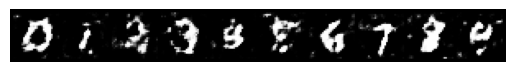

Epoch 2


g_loss: 2.3989434242248535, d_loss: 0.6455416679382324: 100%|██████████| 938/938 [01:11<00:00, 13.20it/s] 

Final: g_loss: 2.232209514961568, d_loss: 0.5771616452665471


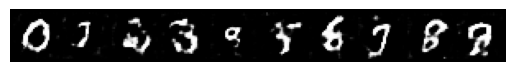

Epoch 3


g_loss: 2.5616133213043213, d_loss: 0.38212576508522034: 100%|██████████| 938/938 [01:10<00:00, 13.27it/s]

Final: g_loss: 2.5004823022305582, d_loss: 0.5118475756379587


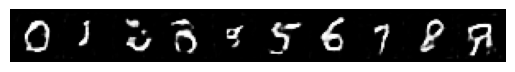

Epoch 4


g_loss: 1.5649340152740479, d_loss: 0.7523699998855591: 100%|██████████| 938/938 [01:10<00:00, 13.26it/s] 

Final: g_loss: 2.5655000864951085, d_loss: 0.526749962364941


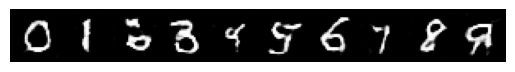

Epoch 5


g_loss: 3.214049816131592, d_loss: 0.5434996485710144: 100%|██████████| 938/938 [01:10<00:00, 13.23it/s]  

Final: g_loss: 2.610834934818211, d_loss: 0.5524691511859009


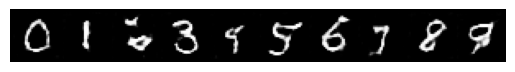

Epoch 6


g_loss: 2.684638023376465, d_loss: 0.32469409704208374: 100%|██████████| 938/938 [01:10<00:00, 13.31it/s] 

Final: g_loss: 2.515511595840647, d_loss: 0.6253201592483246


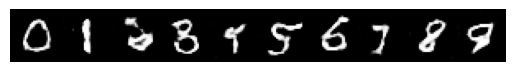

Epoch 7


g_loss: 2.467461585998535, d_loss: 0.4955846965312958: 100%|██████████| 938/938 [01:10<00:00, 13.23it/s]  

Final: g_loss: 2.433354165190573, d_loss: 0.660683175934149


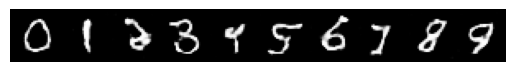

Epoch 8


g_loss: 3.240246057510376, d_loss: 0.6450337171554565: 100%|██████████| 938/938 [01:10<00:00, 13.25it/s] 

Final: g_loss: 2.304593743895417, d_loss: 0.7254828619105476


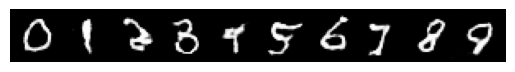

Epoch 9


g_loss: 2.67055344581604, d_loss: 0.9422842860221863: 100%|██████████| 938/938 [01:10<00:00, 13.23it/s]  

Final: g_loss: 2.180089838882245, d_loss: 0.7987290243985556


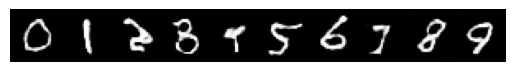

Epoch 10


g_loss: 2.997462749481201, d_loss: 0.5116149187088013: 100%|██████████| 938/938 [01:11<00:00, 13.11it/s]  

Final: g_loss: 2.1124159981097494, d_loss: 0.8270535108440721


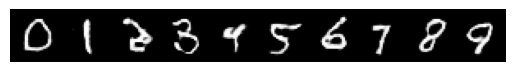

Epoch 11


g_loss: 2.1839957237243652, d_loss: 1.2253971099853516: 100%|██████████| 938/938 [01:11<00:00, 13.11it/s]

Final: g_loss: 2.018786764125834, d_loss: 0.8465757308674774


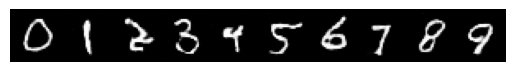

Epoch 12


g_loss: 3.1565346717834473, d_loss: 0.6772834658622742: 100%|██████████| 938/938 [01:11<00:00, 13.18it/s] 

Final: g_loss: 1.99480213602977, d_loss: 0.8652926707255052


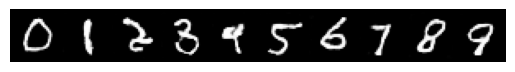

Epoch 13


g_loss: 2.3799047470092773, d_loss: 0.7473701238632202: 100%|██████████| 938/938 [01:12<00:00, 12.86it/s]

Final: g_loss: 1.9464959053596709, d_loss: 0.8690481433100792


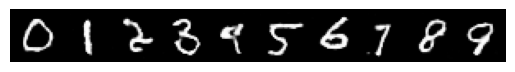

Epoch 14


g_loss: 1.4187674522399902, d_loss: 0.9098765850067139: 100%|██████████| 938/938 [01:12<00:00, 12.97it/s]

Final: g_loss: 1.9421848428846678, d_loss: 0.8757672486846635


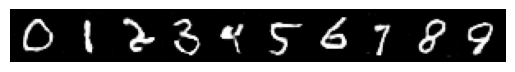

Epoch 15


g_loss: 0.7140024304389954, d_loss: 1.2770897150039673: 100%|██████████| 938/938 [01:11<00:00, 13.11it/s]

Final: g_loss: 1.9458733240742165, d_loss: 0.866278767204488


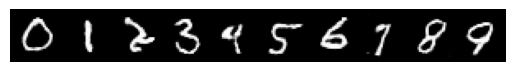

Epoch 16


g_loss: 0.8472649455070496, d_loss: 0.8202508687973022: 100%|██████████| 938/938 [01:11<00:00, 13.07it/s]

Final: g_loss: 1.9742342970613986, d_loss: 0.8425595730479593


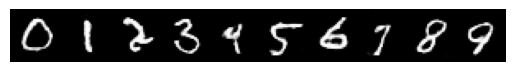

Epoch 17


g_loss: 0.9573543071746826, d_loss: 1.2089699506759644: 100%|██████████| 938/938 [01:10<00:00, 13.26it/s]

Final: g_loss: 1.9981587976852715, d_loss: 0.8354947829106724


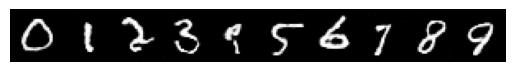

Epoch 18


g_loss: 3.038203477859497, d_loss: 0.7049859762191772: 100%|██████████| 938/938 [01:10<00:00, 13.29it/s] 

Final: g_loss: 2.037562842673457, d_loss: 0.8074921015610319


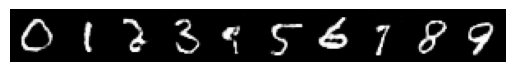

Epoch 19


g_loss: 2.947695732116699, d_loss: 0.5199668407440186: 100%|██████████| 938/938 [01:10<00:00, 13.30it/s]  

Final: g_loss: 2.11586509930935, d_loss: 0.7752099601762381


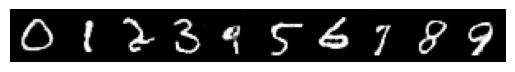

Epoch 20


g_loss: 1.9635145664215088, d_loss: 0.7059816122055054: 100%|██████████| 938/938 [01:10<00:00, 13.29it/s] 

Final: g_loss: 2.136418108937583, d_loss: 0.7561743512336634


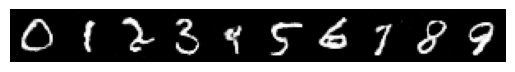

In [13]:
# total number of epochs to train the model
num_epochs = 20

# constant inputs for visualisation
test_noise = torch.randn(10, 100, device=device)
test_labels = torch.LongTensor(np.arange(10)).to(device)

# optimisers
lr = 0.0002
cdis_optimiser = torch.optim.Adam(cdiscriminator.parameters(), lr=lr, betas=(0.5, 0.999))
cgen_optimiser = torch.optim.Adam(cgenerator.parameters(), lr=lr, betas=(0.5, 0.999))

# Train the model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    cdis_loss_sum = 0
    cgen_loss_sum = 0
    data_iter = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, (images, label) in data_iter:
        # Prepare batch
        real_img = images.to(device)
        labels = label.to(device)
        cgenerator.train()
        batch_size = real_img.shape[0]

        # Train discriminator
        cdis_loss = cdis_train_step(
            batch_size, cgenerator, cdiscriminator, cdis_optimiser, loss, real_img, labels,
        )

        # Train generator
        cgen_loss = cgen_train_step(
            batch_size, cgenerator, cdiscriminator, cgen_optimiser, loss
        )

        # Update running loss
        cdis_loss_sum += cdis_loss
        cgen_loss_sum += cgen_loss
        if i % 50 == 0:
            data_iter.set_description(
                "g_loss: {}, d_loss: {}".format(cgen_loss, cdis_loss)
            )

    # average loss over epoch
    print(
        "Final: g_loss: {}, d_loss: {}".format(
            cgen_loss_sum / len(dataloader), cdis_loss_sum / len(dataloader)
        )
    )
    cgenerator.eval()

    # visualise generated images
    sample_images = cgenerator(test_noise, test_labels).cpu()
    grid = (
        torchvision.utils.make_grid(sample_images, nrow=10, padding=2, normalize=True)
        .permute(1, 2, 0)
        .numpy()
    )
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

### Reconstructed Digits
Epoch 20

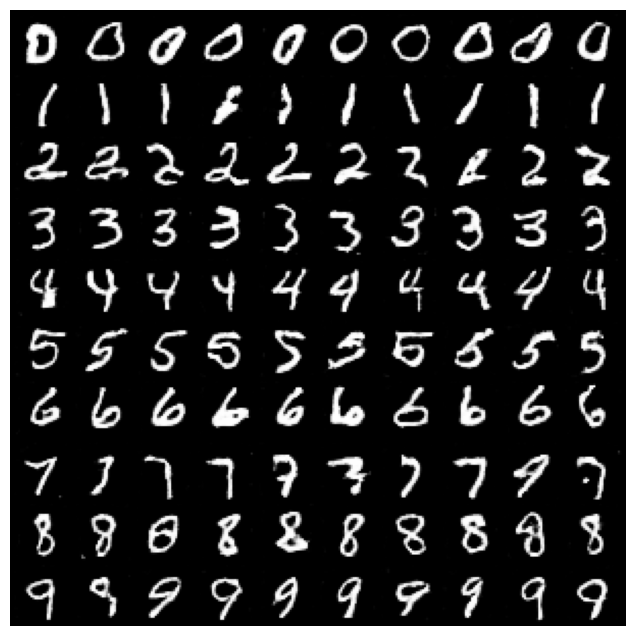

In [14]:
cgenerator.eval()
sample_noise = torch.randn(100, 100, device=device)
sample_labels = torch.LongTensor(np.repeat(np.arange(10), 10)).to(device)
sample_images = cgenerator(sample_noise, sample_labels).cpu()
plt.figure(figsize=(8, 8))
grid = torchvision.utils.make_grid(sample_images, nrow=10, padding=2, normalize=True).permute(1,2,0).numpy()
plt.imshow(grid)
plt.axis("off")
plt.show()

## Encoder Conditional GAN (e-cGAN)

<div>
<img src="ecGAN.png" width="800"/>
</div>

Here I implemented a conditional GAN with an added encoder network attached at the start to generate the latent vector. The arctitecture used here is similar to the paper [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/pdf/1611.07004.pdf) by Isola et al. (2016) without the full U-Net architecture. The encoder can be pretrained for a few epochs just using the L1 loss between the input and the reconstructed image, Although actually, after properly scaling the L1 loss to match the BCE loss I found it wasnt necessary. 

This model obviously converges much faster than the previous two models as the Autoencoder is a much more stable model to train. The conditional GAN also forces the model to reconstruct the correct digit, as before implementing the label conditioning, the model would often reconstruct the wrong digit after the encoder warmup.

### Model Architecture

In [15]:
class EncoderConditionalGenerator(nn.Module):
    def __init__(self, hidden_dim, latent_dim, img_channel, num_classes):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.img_channel = img_channel
        self.num_classes = num_classes

        # Encoder that produces a 100-dimensional latent vector from a 28x28 image
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channel, hidden_dim, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(hidden_dim * 2 * 7 * 7, latent_dim)
        )         
        
        # Embed label and rescale to image channel
        self.label_embedding = nn.Sequential(
            nn.Embedding(num_classes, 49),
            nn.Unflatten(1, (1, 7, 7))
        )

        self.reshape_noise = nn.Sequential(
            # Input
            nn.Linear(latent_dim, hidden_dim * 4 * 7 * 7),
            nn.BatchNorm1d(hidden_dim * 4 * 7 * 7),
            nn.ReLU(True),
            nn.Unflatten(1, (hidden_dim * 4, 7, 7))
        )

        self.upsample = nn.Sequential(
            # First upsample layer (to 14x14)
            nn.ConvTranspose2d(hidden_dim * 4 + 1, hidden_dim * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),
            # Second upsample layer (to 28x28)
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),
            # Collapse to img_channel
            nn.ConvTranspose2d(hidden_dim, img_channel, 5, 1, 2, bias=False),
            nn.Tanh()
        )
    
    def forward(self, z, y):
        y = self.label_embedding(y)
        z = self.encoder(z)
        z = self.reshape_noise(z)
        z = torch.cat((z, y), dim=1)
        return self.upsample(z)
    

    
# Model Hyperparameters
latent_dim = 10
hidden_dim = 64
num_classes = 10

# Initialise Encoder Conditional Generator and Discriminator
ecgenerator = EncoderConditionalGenerator(
    hidden_dim, latent_dim, img_channel, num_classes).to(device)
#print(ecgenerator)

ecdiscriminator = ConditionalDiscriminator(
    hidden_dim, img_channel, num_classes).to(device)
#print(ecdiscriminator)

init_weight(ecgenerator)
init_weight(ecdiscriminator)

### Training Functions

In [16]:
def ecdis_train_step(batch_size, ecgen, cdis, ecdis_optimiser, loss, real_img, labels):
    # Clear Gradients
    ecdis_optimiser.zero_grad()

    # Generate labels
    real_vals = torch.full((batch_size,), real_val, dtype=torch.float, device=device)
    fake_vals = torch.full((batch_size,), fake_val, dtype=torch.float, device=device)

    # Train on Real Data
    validity = cdis(real_img, labels).squeeze(-1)
    real_loss = loss(validity, real_vals)
    
    # Train on Fake Data
    fake = ecgen(real_img, labels)
    validity = cdis(fake, labels).squeeze(-1)
    fake_loss = loss(validity, fake_vals)

    # Update Weights
    ecd_loss = real_loss + fake_loss 
    ecd_loss.backward() 
    ecdis_optimiser.step() 
    return ecd_loss.item() 



def ecgen_train_step(batch_size, aegen, cdis, ecgen_optimiser, loss, loss_enc, real_img, labels):
    # Clear Gradients
    ecgen_optimiser.zero_grad()
    
    # Generate labels
    real_vals = torch.full((batch_size,), real_val, dtype=torch.float, device=device)

    # Train on Fake Data
    fake = aegen(real_img, labels) 
    validity = cdis(fake, labels).squeeze(-1)
    g_loss = loss(validity, real_vals)
    e_loss = loss_enc(real_img, fake) 
    
    # Update Weights
    ecg_loss = g_loss + 10 * e_loss  
    ecg_loss.backward()  
    ecgen_optimiser.step()  
    return ecg_loss.item()  



def cond_enc_train_step(ecgen, ecgen_optimiser, loss_enc, real_img, labels):
    # Clear Gradients
    ecgen_optimiser.zero_grad() 

    # Train on reconstruction
    fake = ecgen(real_img, labels) 
    e_loss = loss_enc(real_img, fake)
    
    # Update Weights
    e_loss = 10 * e_loss
    e_loss.backward() 
    ecgen_optimiser.step() 
    return e_loss.item() 

### Training

Epoch 1


  0%|          | 0/938 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/torch/autograd/__init__.py:251: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695391825142/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
enc_loss: 0.8570941686630249: 100%|██████████| 938/938 [00:38<00:00, 24.31it/s]


Final Avg: enc_loss: 1.229862853725836


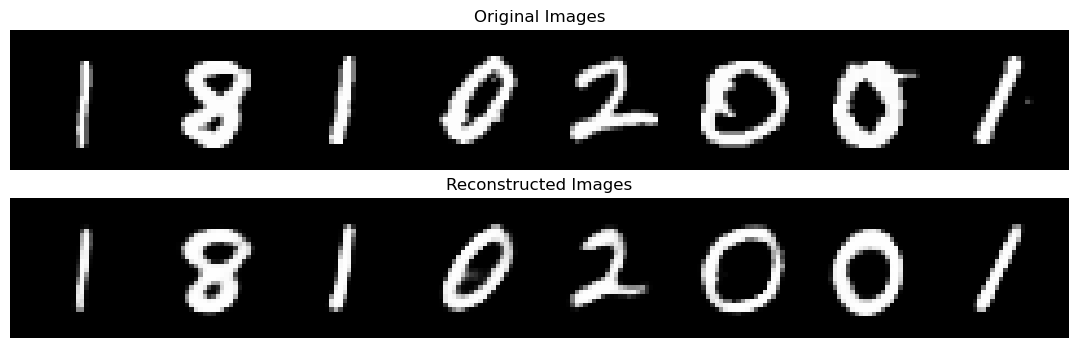

Epoch 2


g_loss: 1.7002034187316895, d_loss: 1.4047542810440063: 100%|██████████| 938/938 [01:19<00:00, 11.83it/s]

Final Avg: g_loss: 1.6706585838342272, d_loss: 1.3941784093120713


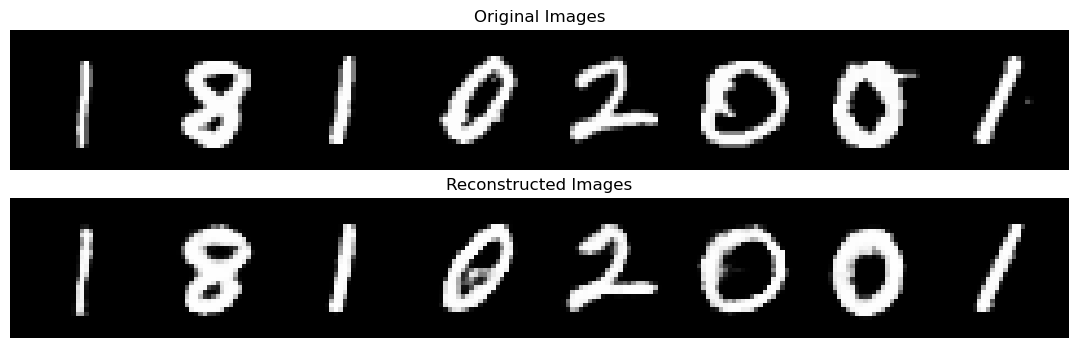

Epoch 3


g_loss: 1.6017463207244873, d_loss: 1.3747707605361938: 100%|██████████| 938/938 [01:18<00:00, 11.91it/s]

Final Avg: g_loss: 1.6301774007679304, d_loss: 1.3920547563129906


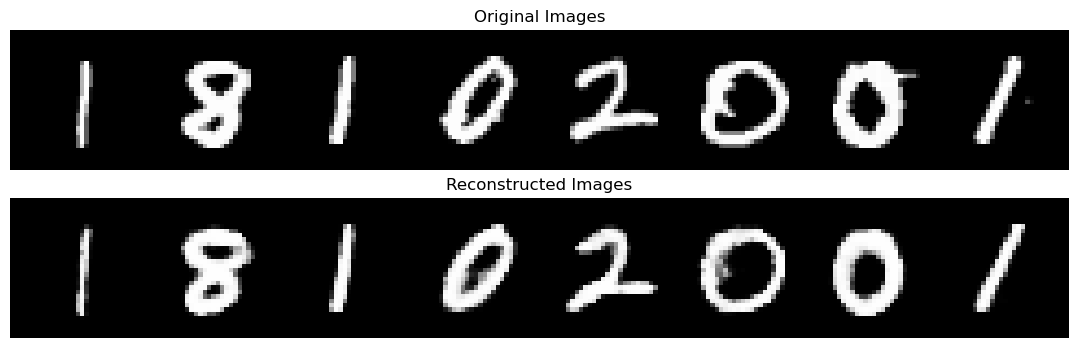

Epoch 4


g_loss: 1.6635277271270752, d_loss: 1.3421841859817505: 100%|██████████| 938/938 [01:17<00:00, 12.09it/s]

Final Avg: g_loss: 1.611873858518946, d_loss: 1.3855156997627796


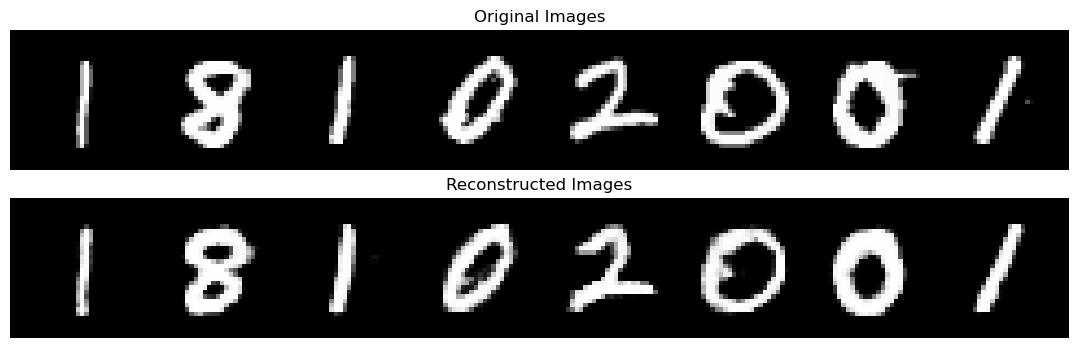

Epoch 5


g_loss: 1.4077881574630737, d_loss: 1.3923845291137695: 100%|██████████| 938/938 [01:17<00:00, 12.18it/s]

Final Avg: g_loss: 1.637738875870003, d_loss: 1.372566025140189


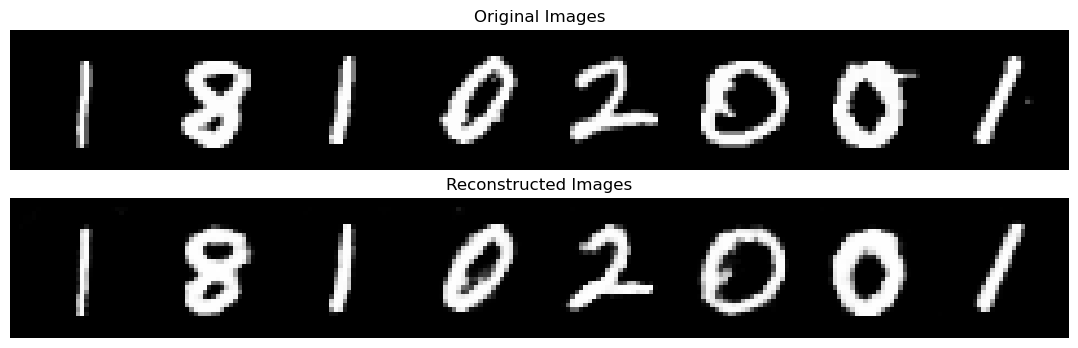

Epoch 6


g_loss: 1.7179129123687744, d_loss: 1.3911232948303223: 100%|██████████| 938/938 [01:18<00:00, 11.88it/s]

Final Avg: g_loss: 1.6683746798714596, d_loss: 1.3538910670321125


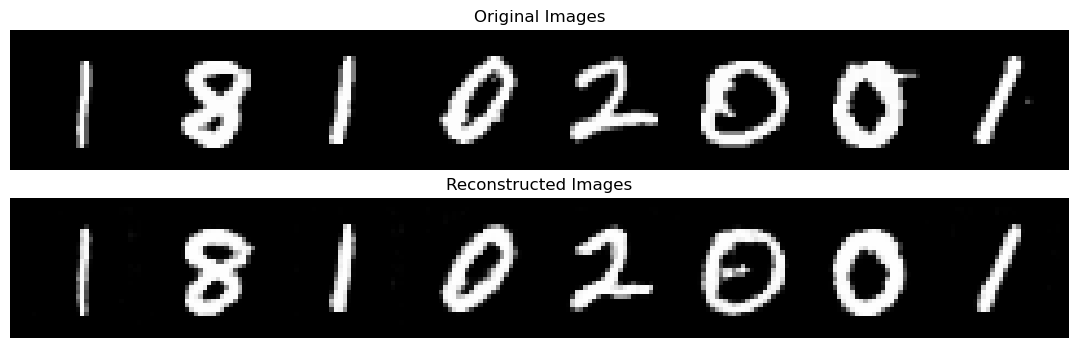

Epoch 7


g_loss: 1.704746961593628, d_loss: 1.3038811683654785: 100%|██████████| 938/938 [01:17<00:00, 12.10it/s] 

Final Avg: g_loss: 1.6782328670721318, d_loss: 1.3497238384126855


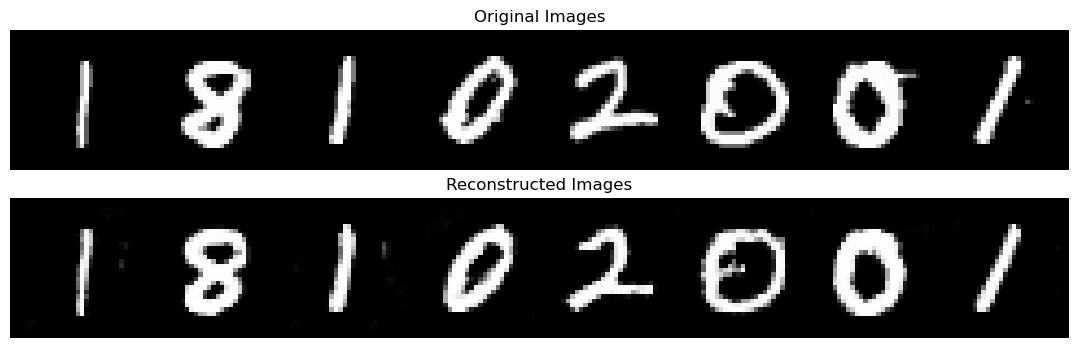

Epoch 8


g_loss: 1.7109274864196777, d_loss: 1.395714282989502: 100%|██████████| 938/938 [01:17<00:00, 12.17it/s] 

Final Avg: g_loss: 1.6634073498914999, d_loss: 1.3535918778956317


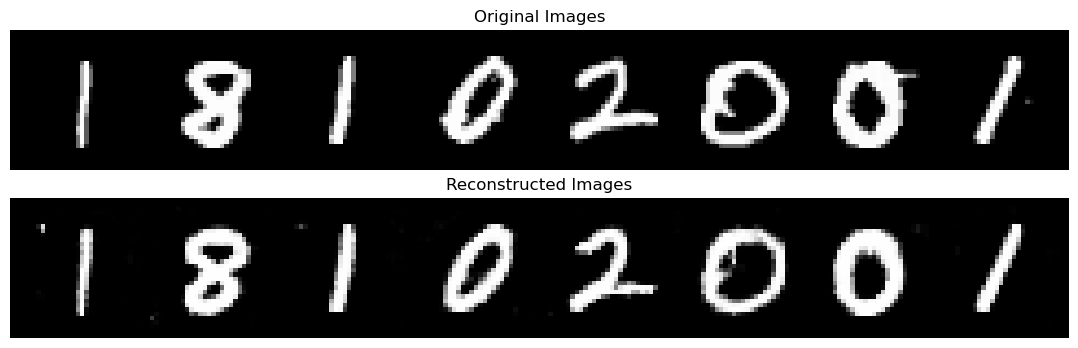

Epoch 9


g_loss: 1.6458650827407837, d_loss: 1.323246717453003: 100%|██████████| 938/938 [01:17<00:00, 12.11it/s] 

Final Avg: g_loss: 1.628506247804109, d_loss: 1.369114564807176


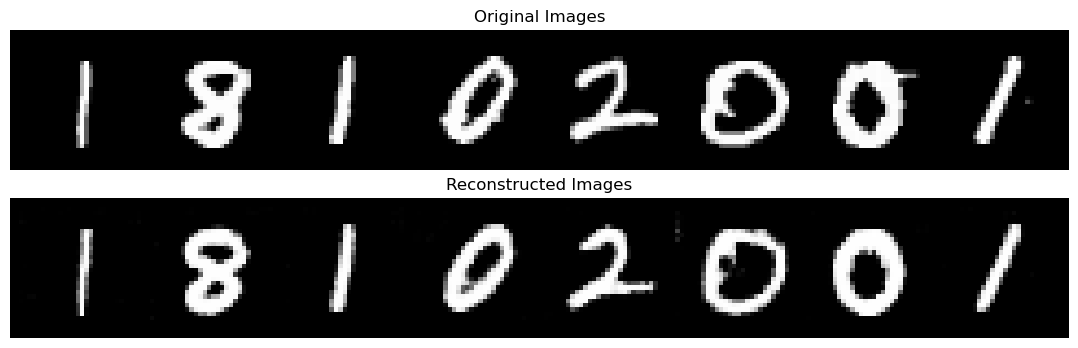

Epoch 10


g_loss: 1.538459300994873, d_loss: 1.3641271591186523: 100%|██████████| 938/938 [01:17<00:00, 12.09it/s] 

Final Avg: g_loss: 1.5974833561159145, d_loss: 1.3789460653943548


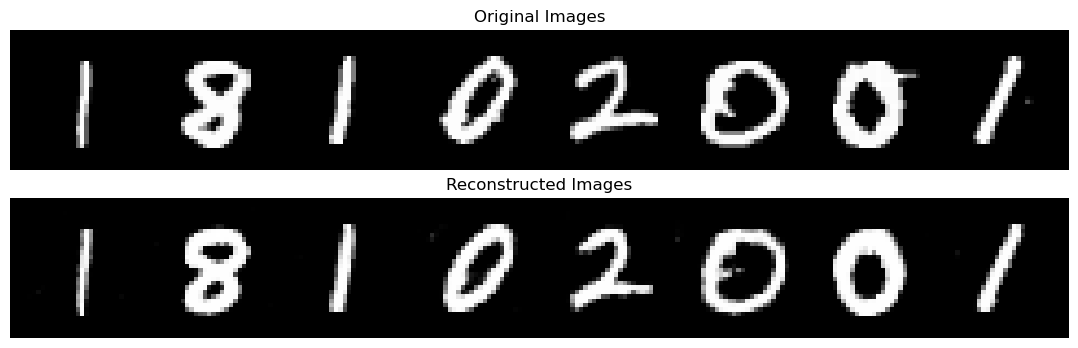

In [17]:
# total number of epochs to train the model
num_epochs = 10
# pre-train the encoder only
enc_warmup_epochs = 1

# Constant images for visualisation
test_imgs, test_labels = next(iter(dataloader))
test_imgs = test_imgs[:8].to(device)
test_labels = test_labels[:8].to(device)

# optimisers
lr=0.0002
ecgen_optimiser = torch.optim.Adam(ecgenerator.parameters(), lr=lr, betas=(0.5, 0.999))
ecdis_optimiser = torch.optim.Adam(ecdiscriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Train the model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    # Avg epoch losses
    ecdis_loss_sum = 0 
    ecgen_loss_sum = 0
    enc_loss_sum = 0
    data_iter = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, (images, labels) in data_iter:
        # Prepare batch 
        real_img = images.to(device)
        labels = labels.to(device)
        ecgenerator.train()
        batch_size = real_img.shape[0]

        # (opt) Pre-train encoder
        if epoch < enc_warmup_epochs:
            enc_loss = cond_enc_train_step(
                ecgenerator, ecgen_optimiser, loss_enc, real_img, labels
            )

            # Update running loss
            enc_loss_sum += enc_loss
            if i % 50 == 0:
                data_iter.set_description('enc_loss: {}'.format(enc_loss))

        # Train discriminator
        else:
            ecdis_loss = ecdis_train_step(
                batch_size, ecgenerator, ecdiscriminator, ecdis_optimiser, loss, real_img, labels
                )
            
            ecgen_loss = ecgen_train_step(
                batch_size, ecgenerator, ecdiscriminator, ecgen_optimiser, loss, loss_enc, real_img,  labels
                )
            
            # Update running loss
            ecdis_loss_sum += ecdis_loss
            ecgen_loss_sum += ecgen_loss
            if i % 50 == 0:
                data_iter.set_description('g_loss: {}, d_loss: {}'.format(ecgen_loss, ecdis_loss))

    # average loss over epoch
    if epoch < enc_warmup_epochs:
        print(
            'Final Avg: enc_loss: {}'.format(
                enc_loss_sum / len(dataloader)
            )
        )
    else:
        print(
            'Final Avg: g_loss: {}, d_loss: {}'.format(
                ecgen_loss_sum / len(dataloader), ecdis_loss_sum / len(dataloader)
            )
        )
    
    ecgenerator.eval()

    # Visualise the progress of the model each epoch
    sample_images = ecgenerator(test_imgs, test_labels).cpu()
    fig, axs = plt.subplots(2, figsize=(16, 4))

    grid1 = torchvision.utils.make_grid(test_imgs.cpu(), nrow=8, padding=2, normalize=True).permute(1,2,0).numpy()
    axs[0].imshow(grid1)
    axs[0].axis("off")
    axs[0].set_title("Original Images")

    grid2 = torchvision.utils.make_grid(sample_images, nrow=8, padding=2, normalize=True).permute(1,2,0).numpy()
    axs[1].imshow(grid2)
    axs[1].axis("off")
    axs[1].set_title("Reconstructed Images")
    plt.show()

### Reconstructed Digits
Epoch 10

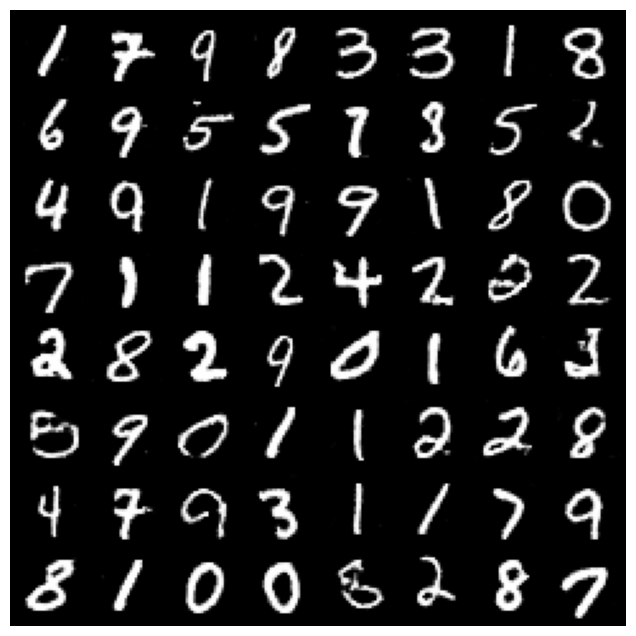

In [18]:
ecgenerator.eval()
sample_imgs, sample_labels = next(iter(dataloader))
sample_imgs = sample_imgs[:64].to(device)
sample_labels = sample_labels[:64].to(device)
sample_images = ecgenerator(sample_imgs, sample_labels).cpu()
plt.figure(figsize=(8, 8))
grid = torchvision.utils.make_grid(sample_images, nrow=8, padding=2, normalize=True).permute(1,2,0).numpy()
plt.imshow(grid)
plt.axis("off")
plt.show()

## Variational Auto Encoder GAN (VAEGAN)

<div>
<img src="VAEGAN.png" width="800"/>
</div>

Here we implement the VAEGAN architecture which substitutes the generator in the GAN architecture with a variational autoencoder. This essentially improves the characteristic over-smoothed quality of VAE images by introducing the adversarial loss from the GAN architecture. This is described in the paper [Autoencoding beyond pixels using a learned similarity metric](https://arxiv.org/pdf/1512.09300.pdf) by Larsen et al. (2015). I initially implemented this as a simple Autoencoder GAN but decided to add the gaussian sampling layer to add more data variety. 

Interestingly I had to really downscale the Kullback-Liebler Divergence term in the ELBO function, otherwise the model would again just experience mode collapse and generate a single low quality digit for every input due to being forced too quickly into a unit gaussian. Again this trains much faster than the GAN architecture but generally the results are a bit smoother than the e-cGAN architecture due to the added gaussian sampling layer. More variety for oversmoothed digits.

### Model Architecture

In [19]:
class AutoEncoderGenerator(nn.Module):
    def __init__(self, hidden_dim, latent_dim, img_channel):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.img_channel = img_channel

        # Encoder that produces a 2 latent vectors from a 28x28 image
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channel, hidden_dim, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(hidden_dim * 2 * 7 * 7, 2 * latent_dim)
        ) 

        self.mu = nn.Linear(2 * latent_dim, latent_dim)
        self.logvar = nn.Linear(2 * latent_dim, latent_dim)

        self.model = nn.Sequential(
            # Input
            nn.Linear(latent_dim, hidden_dim * 4 * 7 * 7),
            nn.BatchNorm1d(hidden_dim * 4 * 7 * 7),
            nn.ReLU(True),
            nn.Unflatten(1, (hidden_dim * 4, 7, 7)),
            # First upsample layer (to 14x14)
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),
            # Second upsample layer (to 28x28)
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),
            # Collapse to img_channel
            nn.ConvTranspose2d(hidden_dim, img_channel, 5, 1, 2, bias=False),
            nn.Tanh()
        )
    
    def reparameterise(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, z):
        z = self.encoder(z)
        mu, logvar = self.mu(z), self.logvar(z)
        z = self.reparameterise(mu, logvar)
        return self.model(z), mu, logvar
    

    
# Model Hyperparameters
latent_dim = 10
hidden_dim = 64

# Initialise Encoder Conditional Generator and Discriminator
aegenerator = AutoEncoderGenerator(
    hidden_dim, latent_dim, img_channel).to(device)
#print(aegenerator)

aediscriminator = Discriminator(
    hidden_dim, img_channel).to(device)
#print(aediscriminator)

init_weight(aegenerator)
init_weight(aediscriminator)

### ELBO Loss Function

In [20]:
def ELBO(recon_x, x, mu, logvar, loss, beta):
    recon = loss(recon_x, x)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kld, recon, kld

### Training Functions

In [21]:
def aedis_train_step(batch_size, aegen, dis, aedis_optimiser, loss, real_img):
    # Clear Gradients
    aedis_optimiser.zero_grad()

    # Generate labels
    real_vals = torch.full((batch_size,), real_val, dtype=torch.float, device=device)
    fake_vals = torch.full((batch_size,), fake_val, dtype=torch.float, device=device)

    # Train on Real Data
    validity = dis(real_img).squeeze(-1)
    real_loss = loss(validity, real_vals)
    
    # Train on Fake Data
    fake = aegen(real_img)[0]
    validity = dis(fake).squeeze(-1)
    fake_loss = loss(validity, fake_vals)

    # Update Weights
    dloss = real_loss + fake_loss 
    dloss.backward() 
    aedis_optimiser.step() 
    return dloss.item() 



def aegen_train_step(batch_size, aegen, dis, aegen_optimiser, loss, loss_enc, real_img):
    # Clear Gradients
    aegen_optimiser.zero_grad()
    
    # Generate labels
    real_vals = torch.full((batch_size,), real_val, dtype=torch.float, device=device)

    # Train on Fake Data
    fake, mu, logvar = aegen(real_img) 
    validity = dis(fake).squeeze(-1)
    g_loss = loss(validity, real_vals)
    vae_loss = ELBO(fake, real_img, mu, logvar, loss_enc, 0.00005)[0]
    
    # Update Weights
    aeg_loss = g_loss + 10 * vae_loss  
    aeg_loss.backward()  
    aegen_optimiser.step()  
    return aeg_loss.item()  



def enc_train_step(aegen, aegen_optimiser, loss_enc, real_img):
    # Clear Gradients
    aegen_optimiser.zero_grad() 

    # Train on reconstruction
    fake, mu, logvar = aegen(real_img) 
    vae_loss, BCE, KLD = ELBO(fake, real_img, mu, logvar, loss_enc, 0.00005)
    
    # Update Weights
    vae_loss = 10 * vae_loss
    vae_loss.backward() 
    aegen_optimiser.step() 
    return vae_loss.item(), BCE.item(), KLD.item() 

### Training

Epoch 1


g_loss: 2.6136412620544434, d_loss: 1.3309895992279053: 100%|██████████| 938/938 [01:06<00:00, 14.07it/s]


Final Avg: g_loss: 3.0046402820900306, d_loss: 1.254461363370993


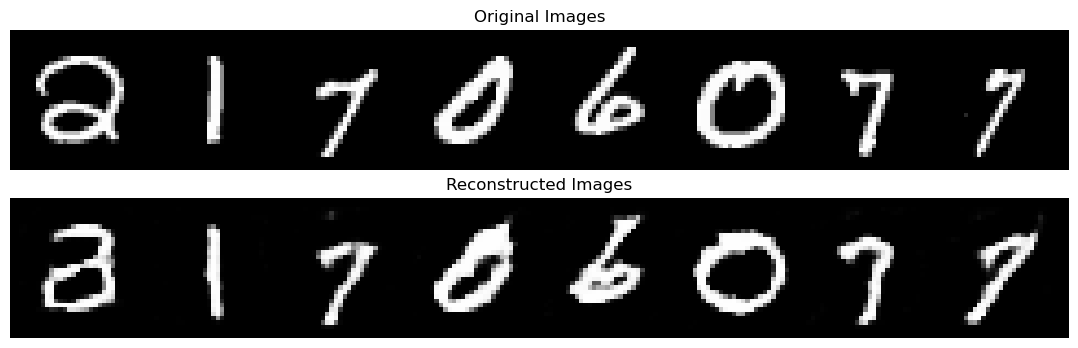

Epoch 2


g_loss: 2.5598526000976562, d_loss: 1.3578710556030273: 100%|██████████| 938/938 [01:04<00:00, 14.61it/s]

Final Avg: g_loss: 2.5251606008899747, d_loss: 1.3331917575173287


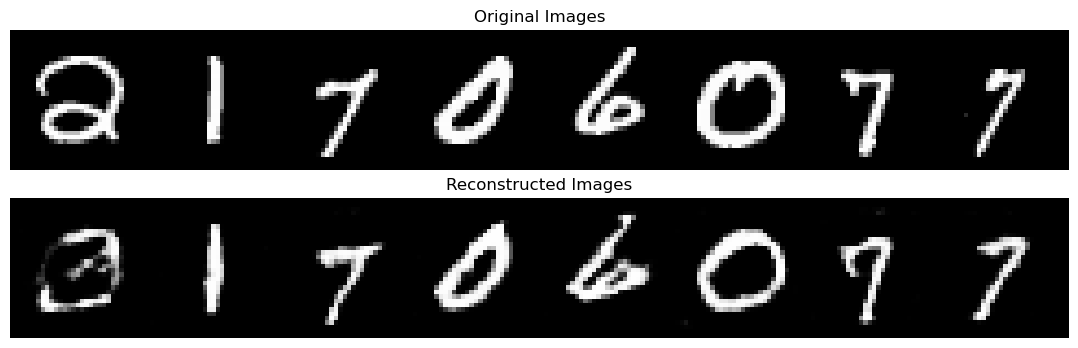

Epoch 3


g_loss: 2.4648654460906982, d_loss: 1.2339017391204834: 100%|██████████| 938/938 [01:04<00:00, 14.63it/s]

Final Avg: g_loss: 2.4900358621753864, d_loss: 1.3303338263843105


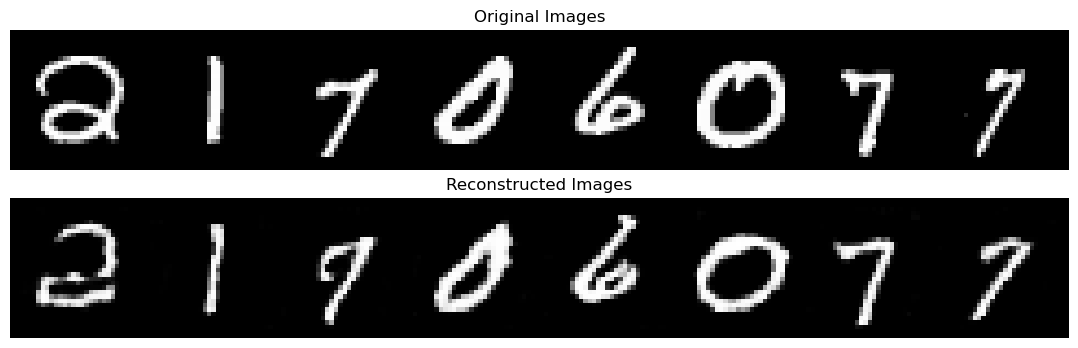

Epoch 4


g_loss: 2.7293171882629395, d_loss: 1.3204529285430908: 100%|██████████| 938/938 [01:03<00:00, 14.71it/s]

Final Avg: g_loss: 2.477048833360042, d_loss: 1.3266981611373836


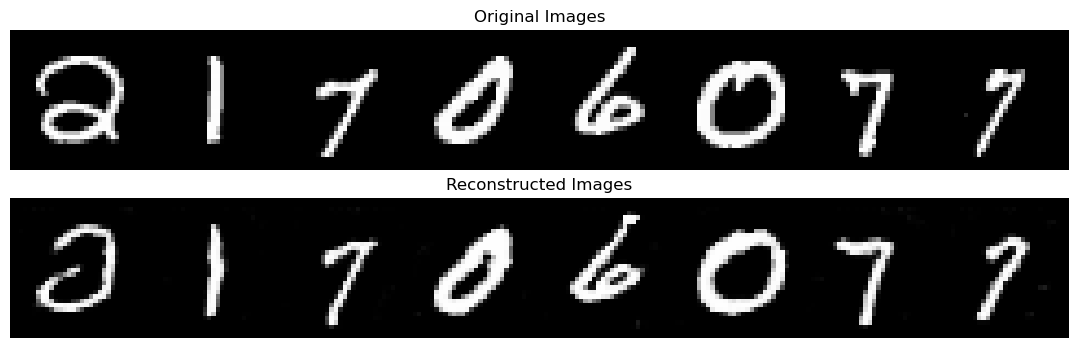

Epoch 5


g_loss: 2.5812554359436035, d_loss: 1.415199637413025: 100%|██████████| 938/938 [01:03<00:00, 14.79it/s] 

Final Avg: g_loss: 2.4632058610031597, d_loss: 1.3249831288608152


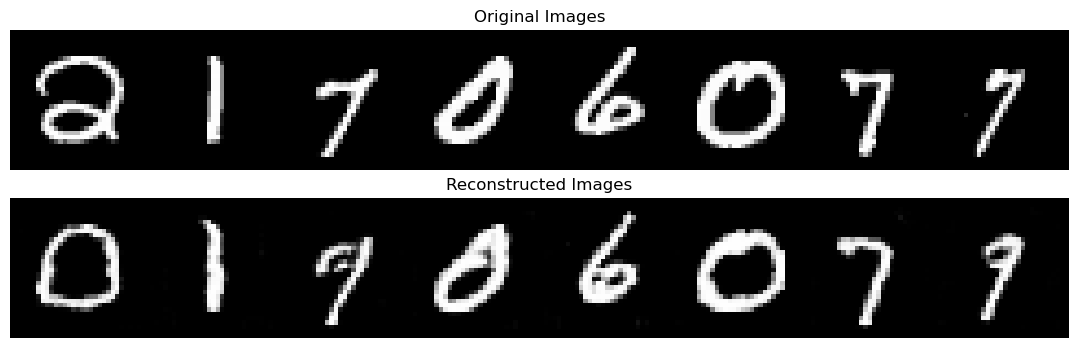

Epoch 6


g_loss: 2.3788771629333496, d_loss: 1.350652813911438: 100%|██████████| 938/938 [01:04<00:00, 14.61it/s] 

Final Avg: g_loss: 2.4261421973008845, d_loss: 1.3398637649601202


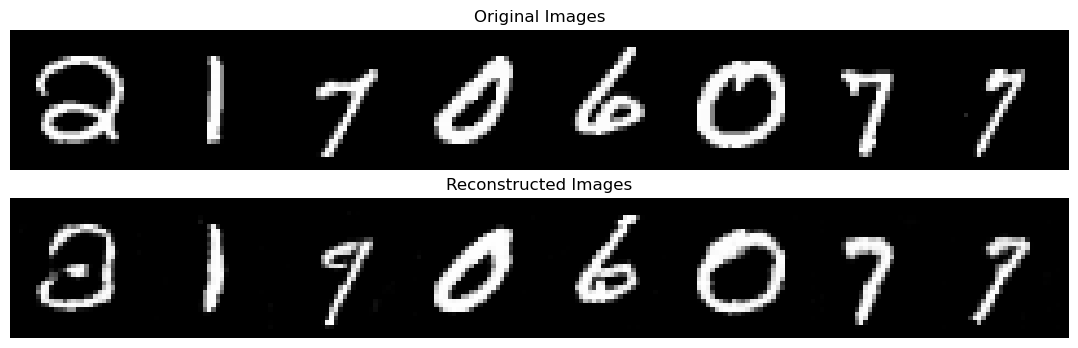

Epoch 7


g_loss: 2.3104701042175293, d_loss: 1.3494560718536377: 100%|██████████| 938/938 [01:04<00:00, 14.59it/s]

Final Avg: g_loss: 2.3722411023019983, d_loss: 1.3602095084912234


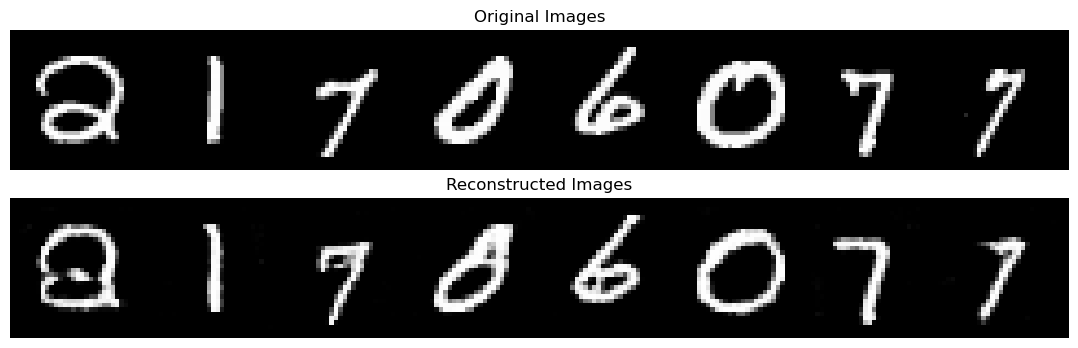

Epoch 8


g_loss: 2.194345712661743, d_loss: 1.3561196327209473: 100%|██████████| 938/938 [01:04<00:00, 14.64it/s] 

Final Avg: g_loss: 2.3269136724695723, d_loss: 1.3755899740180482


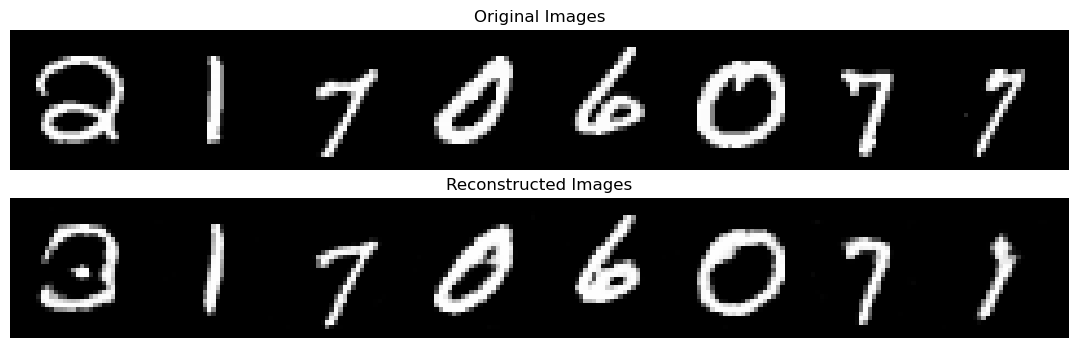

Epoch 9


g_loss: 2.271880865097046, d_loss: 1.3808960914611816: 100%|██████████| 938/938 [01:04<00:00, 14.64it/s] 

Final Avg: g_loss: 2.2820196042437035, d_loss: 1.3838852059358218


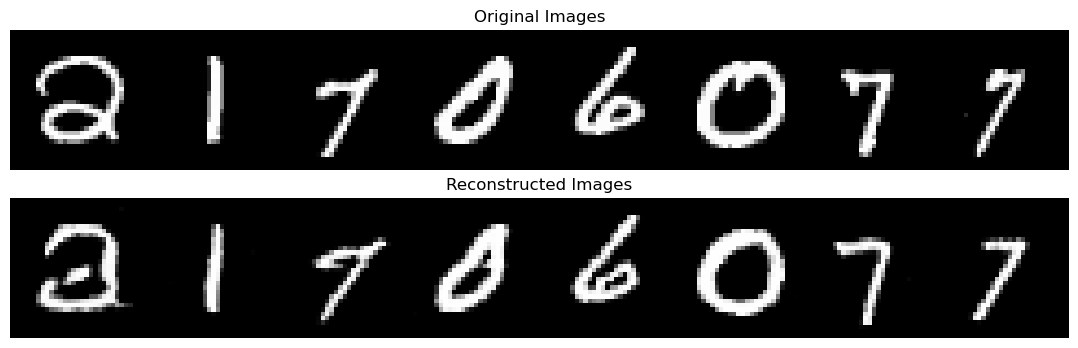

Epoch 10


g_loss: 2.324091672897339, d_loss: 1.3897099494934082: 100%|██████████| 938/938 [01:03<00:00, 14.70it/s] 

Final Avg: g_loss: 2.257144750054203, d_loss: 1.3897997478940594


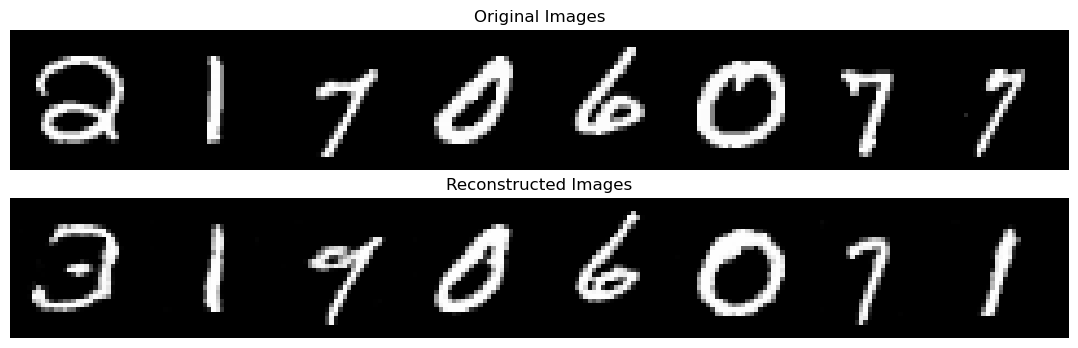

In [22]:
# total number of epochs to train the model
num_epochs = 10
# pre-train the encoder only
enc_warmup_epochs = 0

# Constant images for visualisation
test_imgs = next(iter(dataloader))[0][:8].to(device)

# optimisers
lr=0.0002
ecgen_optimiser = torch.optim.Adam(aegenerator.parameters(), lr=lr, betas=(0.5, 0.999))
ecdis_optimiser = torch.optim.Adam(aediscriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Train the model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    # Avg epoch losses
    ecdis_loss_sum = 0 
    ecgen_loss_sum = 0
    enc_loss_sum = 0
    data_iter = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, (images, _) in data_iter:
        # Prepare batch 
        real_img = images.to(device)
        aegenerator.train()
        batch_size = real_img.shape[0]

        # (opt) Pre-train encoder
        if epoch < enc_warmup_epochs:
            enc_loss, recon, kld = enc_train_step(
                aegenerator, ecgen_optimiser, loss_enc, real_img
            )

            # Update running loss
            enc_loss_sum += enc_loss
            if i % 50 == 0:
                data_iter.set_description('enc_loss: {}, Recon: {}, KLD: {}'.format(enc_loss, recon, kld))
                #data_iter.set_description('enc_loss: {}'.format(enc_loss))

        # Train discriminator
        else:
            ecdis_loss = aedis_train_step(
                batch_size, aegenerator, aediscriminator, ecdis_optimiser, loss, real_img
                )
            
            ecgen_loss = aegen_train_step(
                batch_size, aegenerator, aediscriminator, ecgen_optimiser, loss, loss_enc, real_img
                )
            
            # Update running loss
            ecdis_loss_sum += ecdis_loss
            ecgen_loss_sum += ecgen_loss
            if i % 50 == 0:
                data_iter.set_description('g_loss: {}, d_loss: {}'.format(ecgen_loss, ecdis_loss))

    # average loss over epoch
    if epoch < enc_warmup_epochs:
        print('Final Avg: enc_loss: {}'.format(enc_loss_sum / len(dataloader)))
    else:
        print('Final Avg: g_loss: {}, d_loss: {}'.format(ecgen_loss_sum / len(dataloader), ecdis_loss_sum / len(dataloader))) # Print the loss values
    
    # Visualise the progress of the model each epoch
    aegenerator.eval()
    sample_images = aegenerator(test_imgs)[0].cpu()
    fig, axs = plt.subplots(2, figsize=(16, 4))

    grid1 = torchvision.utils.make_grid(test_imgs.cpu(), nrow=8, padding=2, normalize=True).permute(1,2,0).numpy()
    axs[0].imshow(grid1)
    axs[0].axis("off")
    axs[0].set_title("Original Images")

    grid2 = torchvision.utils.make_grid(sample_images, nrow=8, padding=2, normalize=True).permute(1,2,0).numpy()
    axs[1].imshow(grid2)
    axs[1].axis("off")
    axs[1].set_title("Reconstructed Images")
    plt.show()

### Reconstructed Digits
Epoch 10

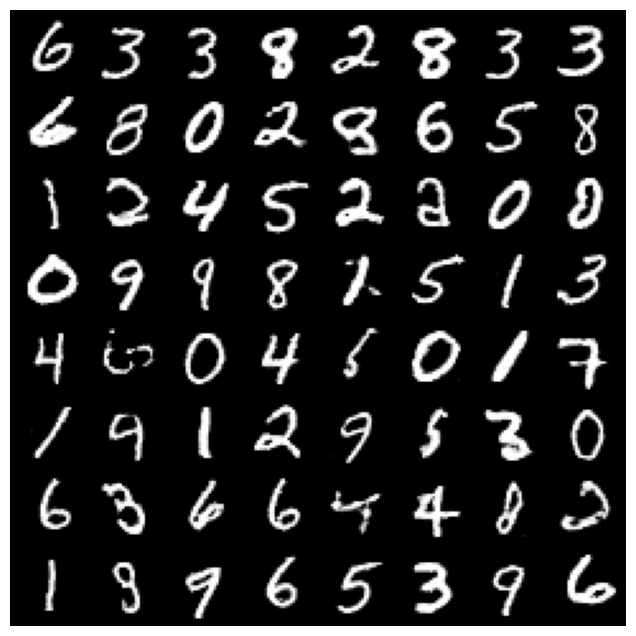

In [23]:
aegenerator.eval()
sample_images = aegenerator(next(iter(dataloader))[0].to(device))[0].cpu()
plt.figure(figsize=(8, 8))
grid = torchvision.utils.make_grid(sample_images, nrow=8, padding=2, normalize=True).permute(1,2,0).numpy()
plt.imshow(grid)
plt.axis("off")
plt.show()
